# <font color=#023F7C> **Machine Learning, Explainability and Deep Learning** </font>

<font color=#023F7C>**Hi! PARIS DataBootcamp 2024 🚀**</font> <br>


<img src = https://www.hi-paris.fr/wp-content/uploads/2020/09/logo-hi-paris-retina.png width = "300" height = "200" >


**Name**: Théo VIDAL           <br>
**School**: ENSTA Paris         <br>
**Group number**: 7    <br>
**Track**: Intermediate

Note: this notebook has been executed on my personal computer using DataSpell (JetBrains IDE).

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None) # Show all columns

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Exploratory Data Analysis

In [2]:
path = r"data/tennis_matches.csv"
matches_df = pd.read_csv(path)

In [3]:
matches_df.describe()

,age,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,rank,rank_points,won,draw_size,tourney_date,best_of,minutes
count,27893.000000,27893.000000,27893.000000,27893.000000,27893.000000,27893.000000,27893.000000,27893.000000,27893.000000,27893.000000,27893.000000,27893.000000,27893.000000,27893.000000,27893.000000,27893.000000,27893.000000
mean,27.444144,6.309217,3.065321,81.154232,50.112107,35.712688,15.629369,12.674076,4.193059,6.924067,84.694153,1484.134478,0.466067,60.063672,2019.401606,3.398881,112.906105
std,4.658025,5.560199,2.470890,29.274646,19.216345,14.265530,6.936216,4.249050,3.273731,4.476780,127.627869,1693.921692,0.498856,41.682329,1.777724,0.799174,42.499048
min,16.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2017.000000,3.000000,7.000000
25%,23.700000,2.000000,1.000000,59.000000,36.000000,26.000000,11.000000,10.000000,2.000000,4.000000,27.000000,629.000000,0.000000,32.000000,2018.000000,3.000000,81.000000
50%,27.300000,5.000000,3.000000,76.000000,47.000000,33.000000,15.000000,12.000000,4.000000,6.000000,56.000000,947.000000,0.000000,32.000000,2019.000000,3.000000,106.000000
75%,30.900000,9.000000,4.000000,98.000000,61.000000,44.000000,20.000000,15.000000,6.000000,10.000000,95.000000,1604.000000,1.000000,64.000000,2021.000000,3.000000,137.000000
max,42.500000,67.000000,26.000000,291.000000,218.000000,171.000000,56.000000,50.000000,27.000000,38.000000,2146.000000,12560.000000,1.000000,128.000000,2022.000000,5.000000,987.000000


We will start by creating two lists with the continuous and categorical variables of our dataset. <br>
Note that we are not including `won` in both lists since we shouldn't apply data preprocessing to it

In [4]:
# List of continuous variables
continuous_var = list(matches_df.select_dtypes(include=[int, float]).columns)
continuous_var.remove("won")

# List of categorical variables
categorical_var = list(matches_df.select_dtypes(include=["object"]).columns)

### Correlation Matrix

In [5]:
corr_matrix = matches_df[continuous_var].corr(numeric_only=True)

<Axes: >

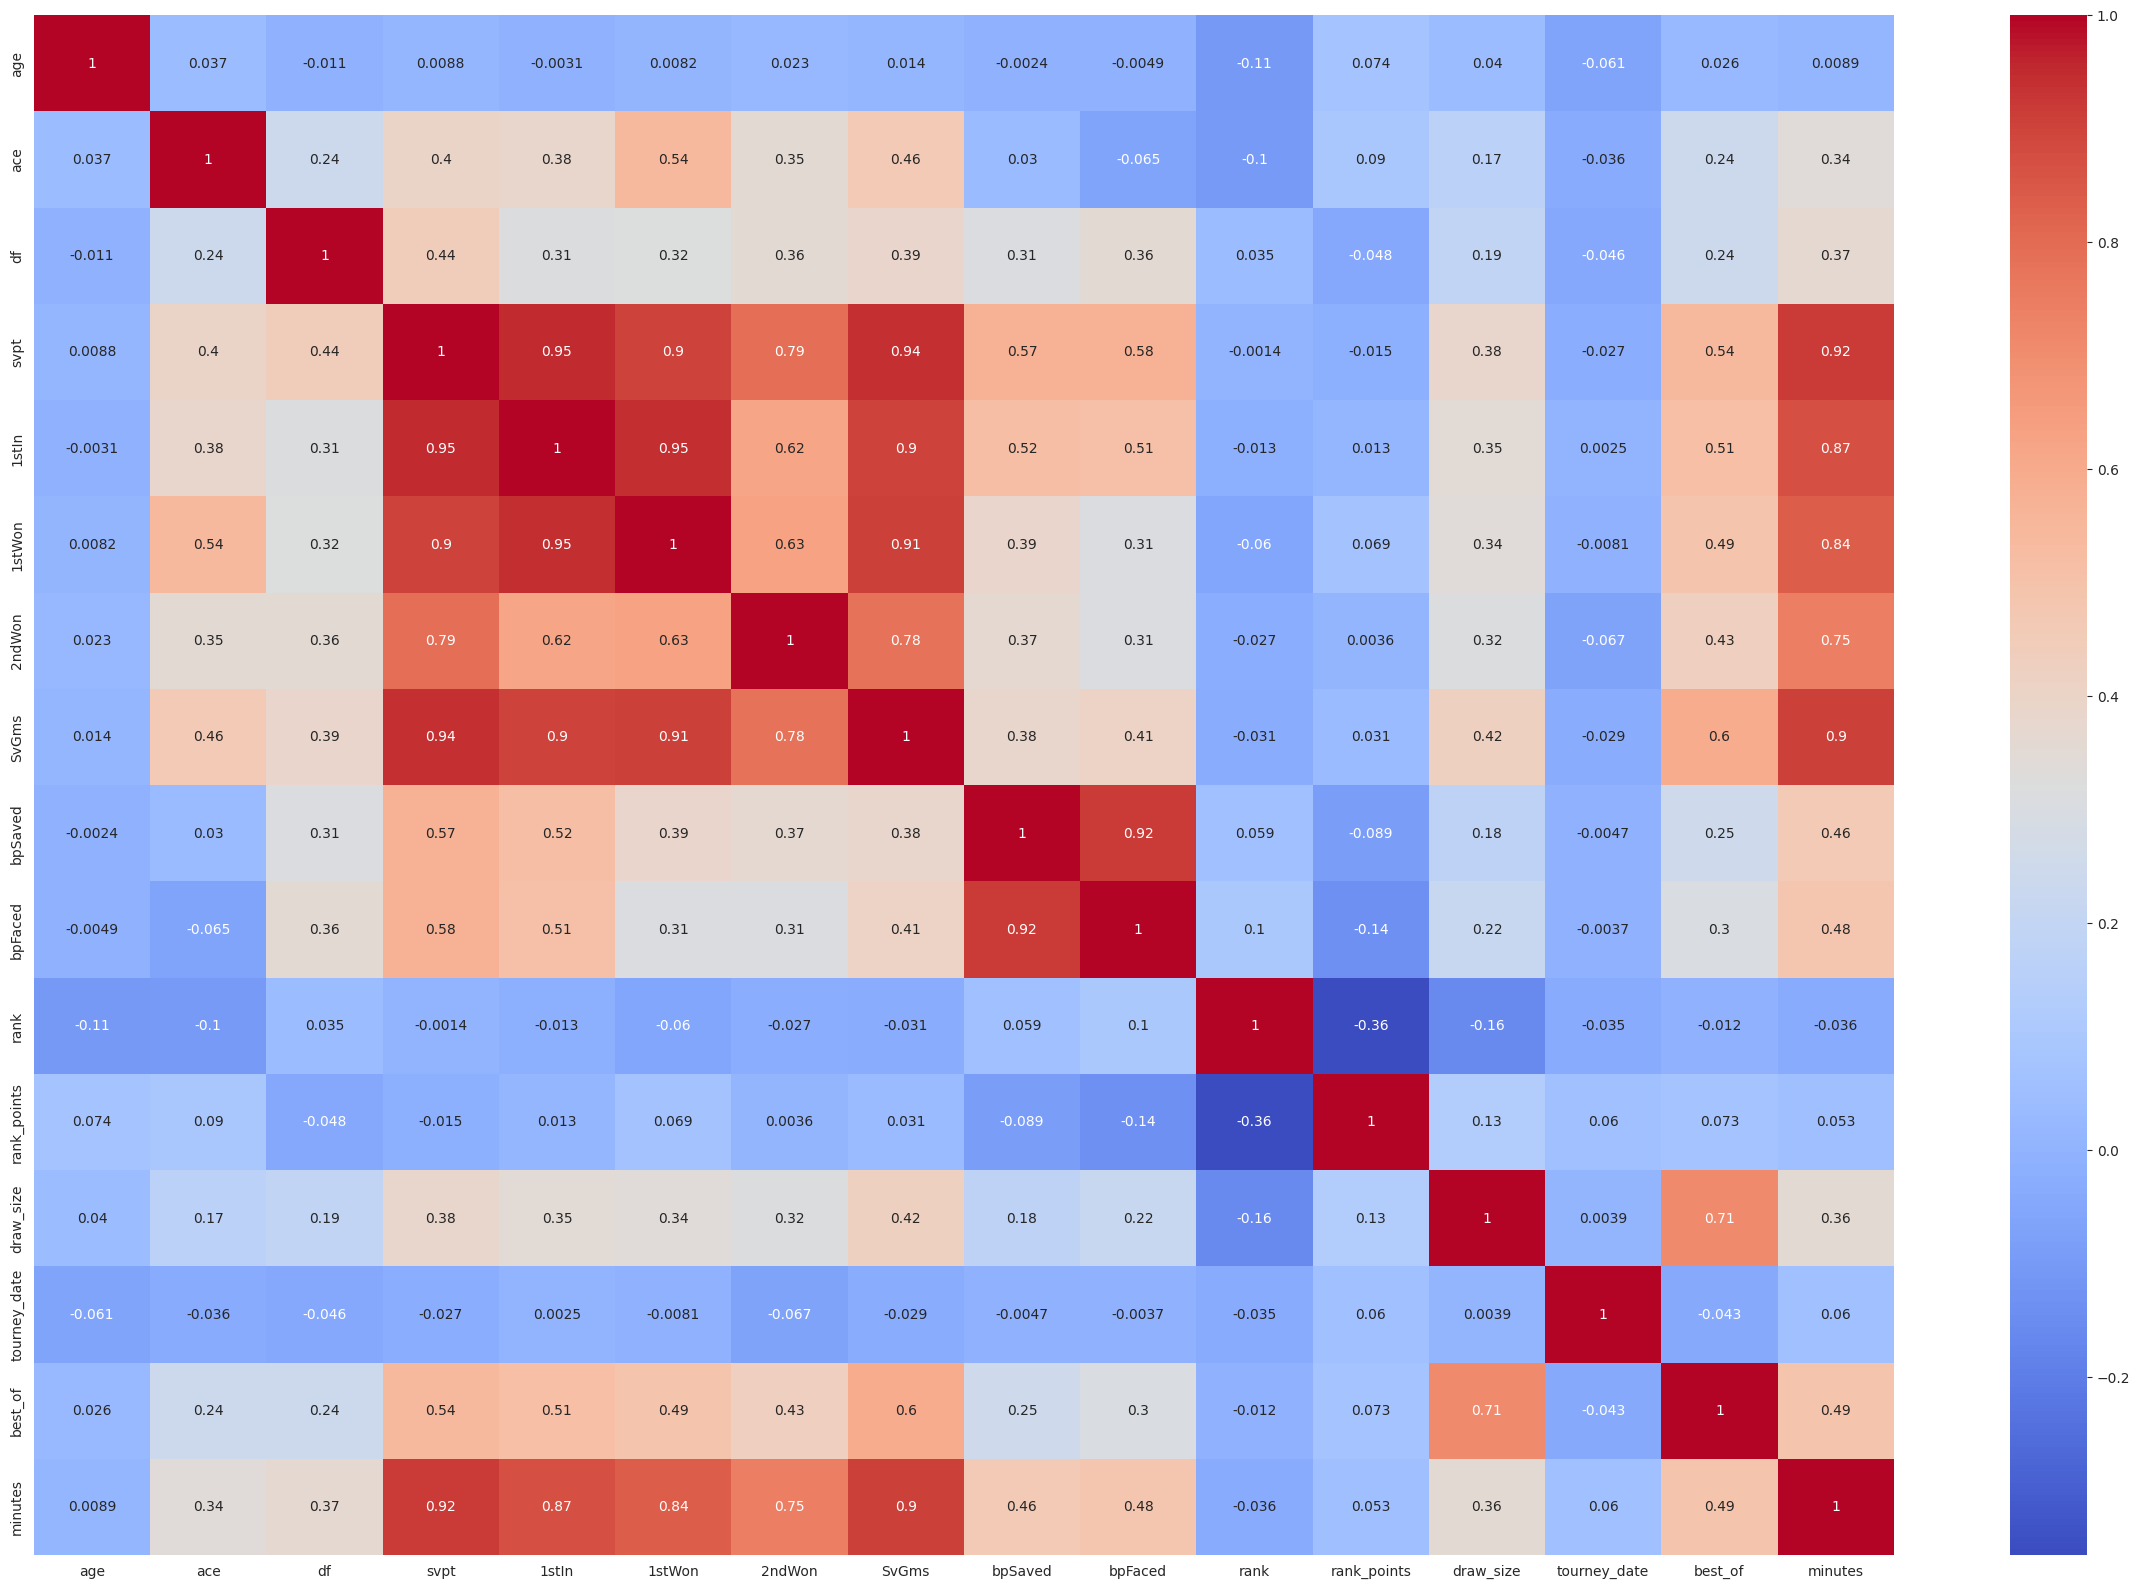

In [6]:
plt.figure(figsize=(30, 20))
sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm')

- "svpt", "1stin", "1stWon", "2ndWon" and "SvGms" tend to be correlated to one each other ; and they are highly correlated with "minutes"

### Class distribution between won and lost plays

/tmp/ipykernel_18458/235782232.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=proportions, palette=['red', 'green'])


Text(0, 0.5, 'Proportion')

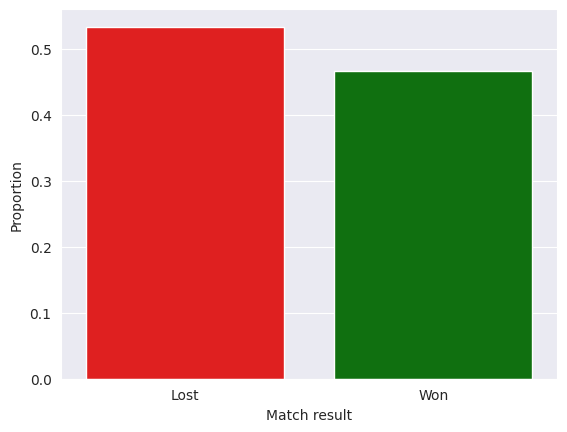

In [7]:
proportions = matches_df["won"].value_counts() / len(matches_df)
sns.barplot(data=proportions, palette=['red', 'green'])
plt.xticks([0, 1], labels=['Lost', 'Won'])
plt.xlabel('Match result')
plt.ylabel('Proportion')

In [8]:
proportions

won
0    0.533933
1    0.466067
Name: count, dtype: float64

It's not a perfect 50/50 cut but both classes are rather balanced.

In [9]:
matches_df.groupby('tourney_level')['rank_points'].mean()

tourney_level
A    1220.544858
D     816.783206
F    3906.585774
G    1797.665058
M    2020.278886
Name: rank_points, dtype: float64

### Continuous variables distribution

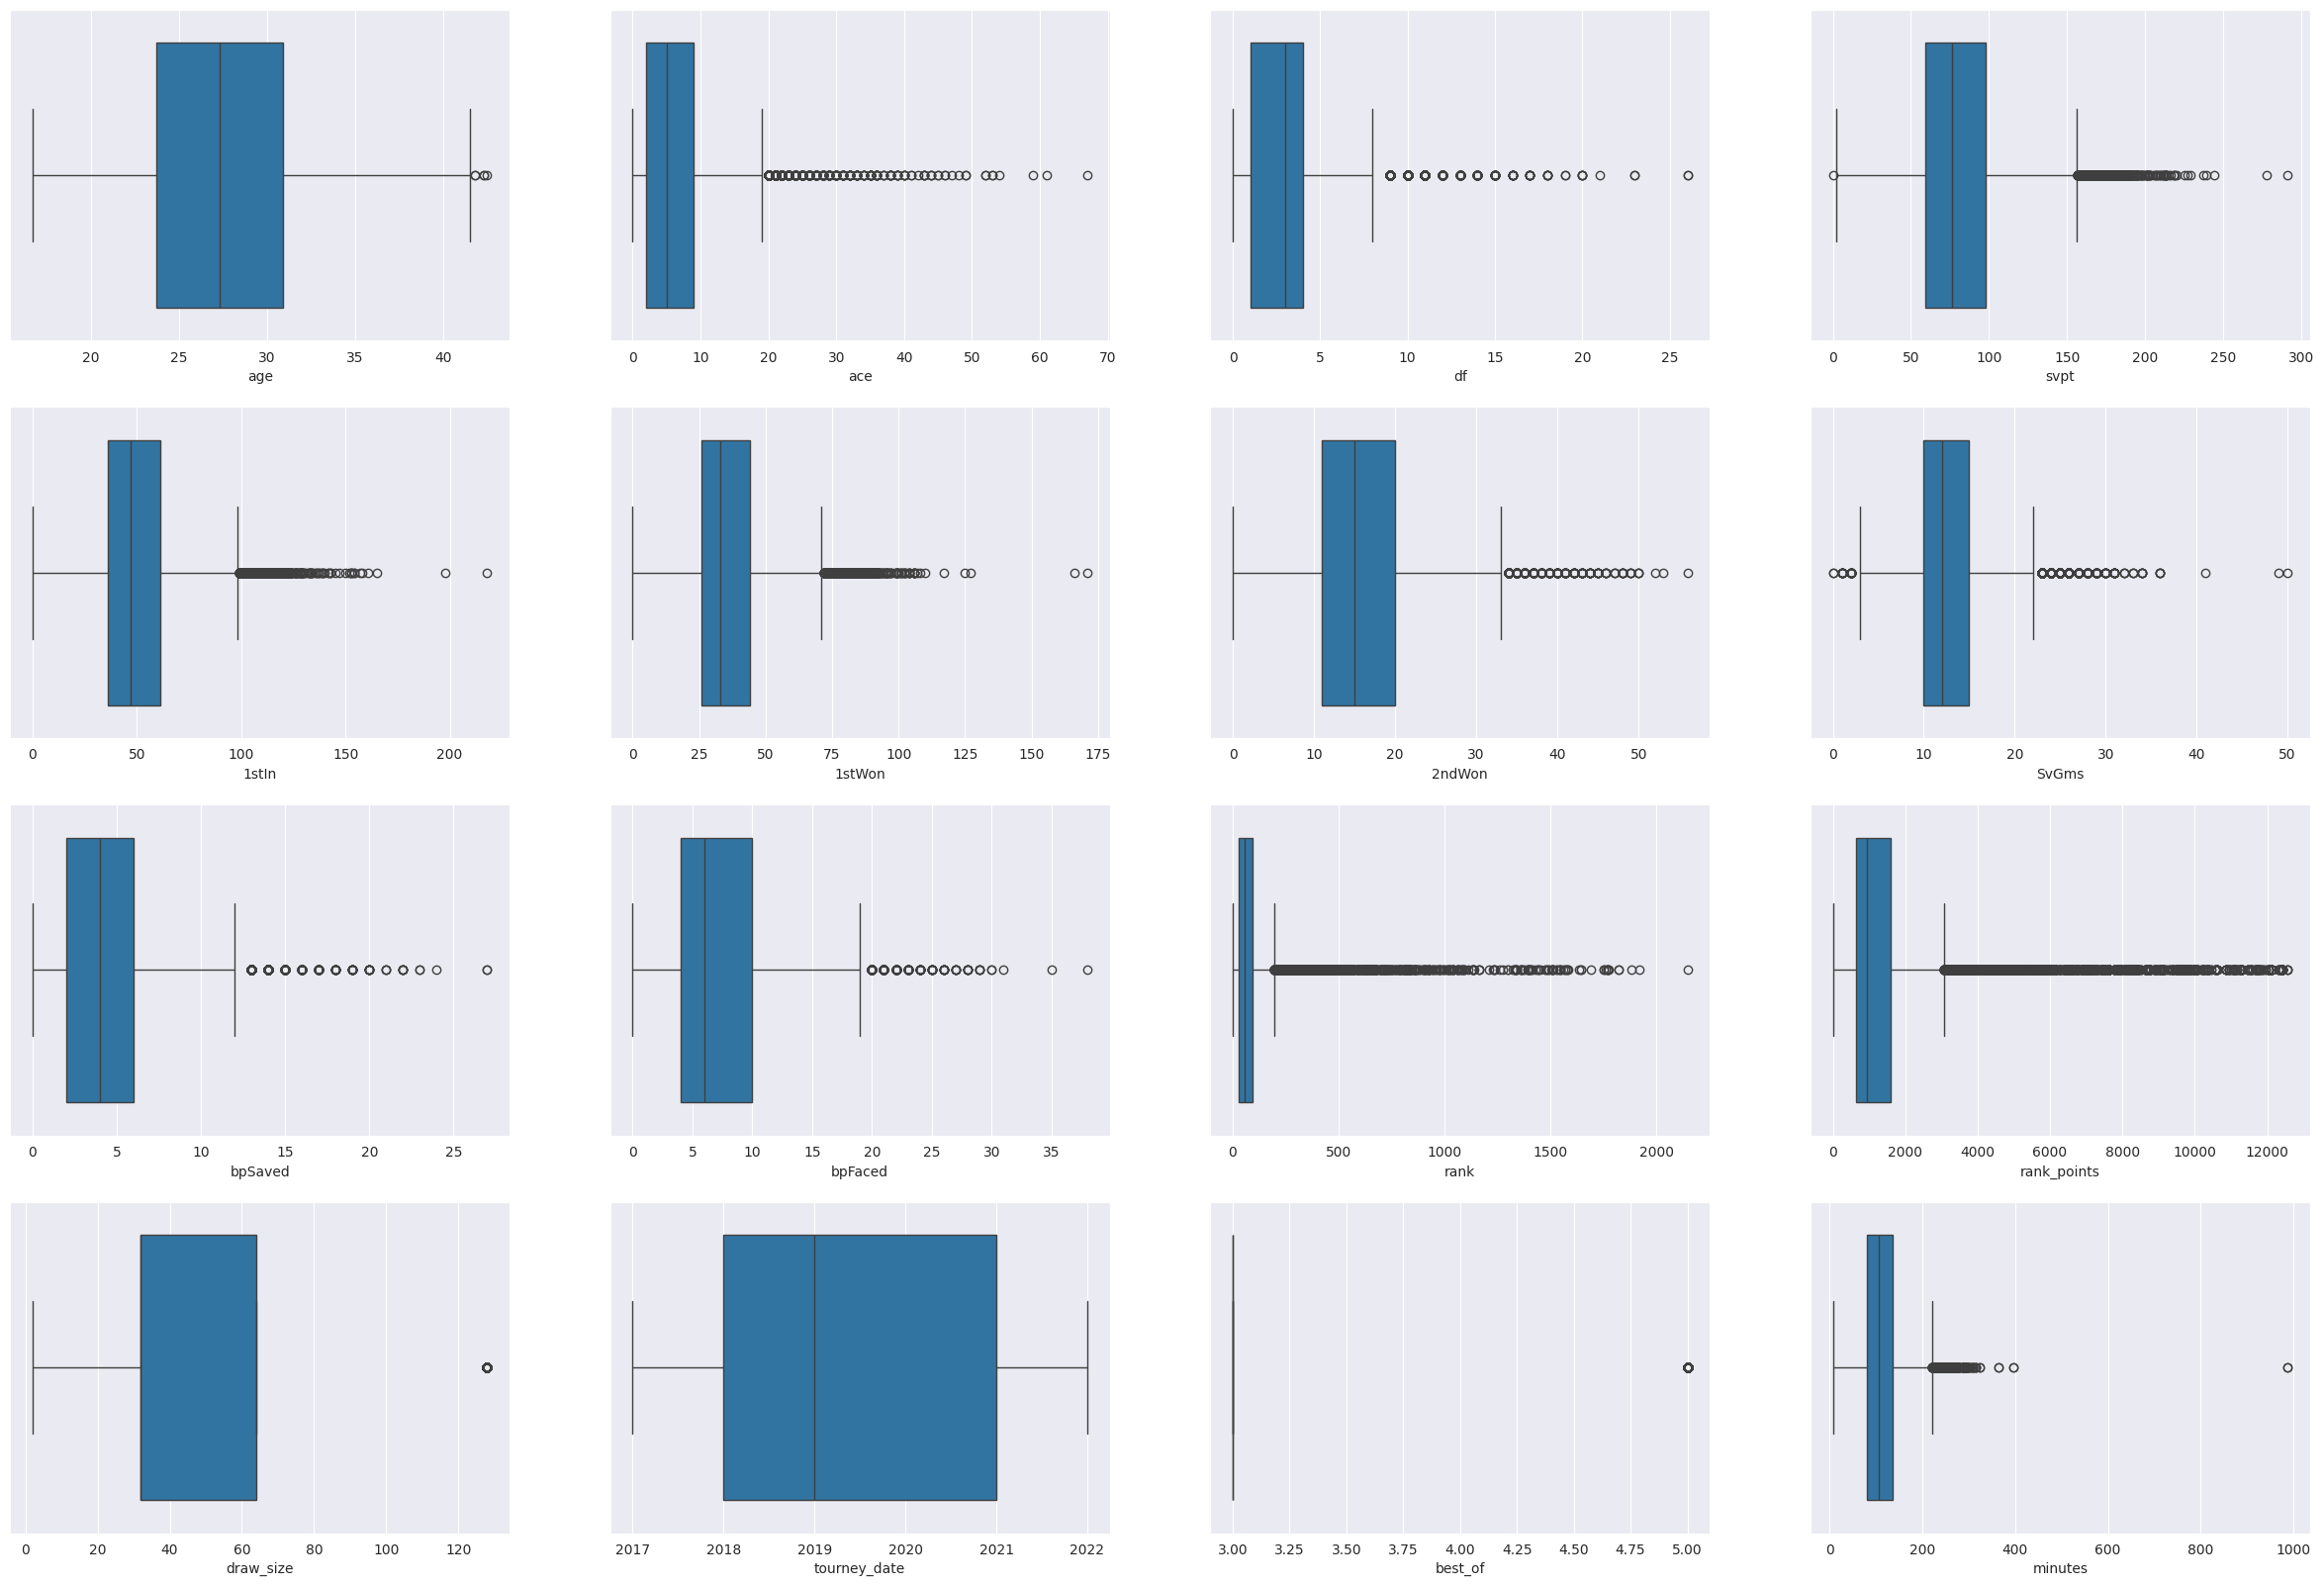

In [10]:
nb_continuous_var = len(continuous_var)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(30, 20))

for i, col in enumerate(continuous_var):
  plt.sca(axs[i // 4, i % 4])
  sns.boxplot(x=matches_df[col])

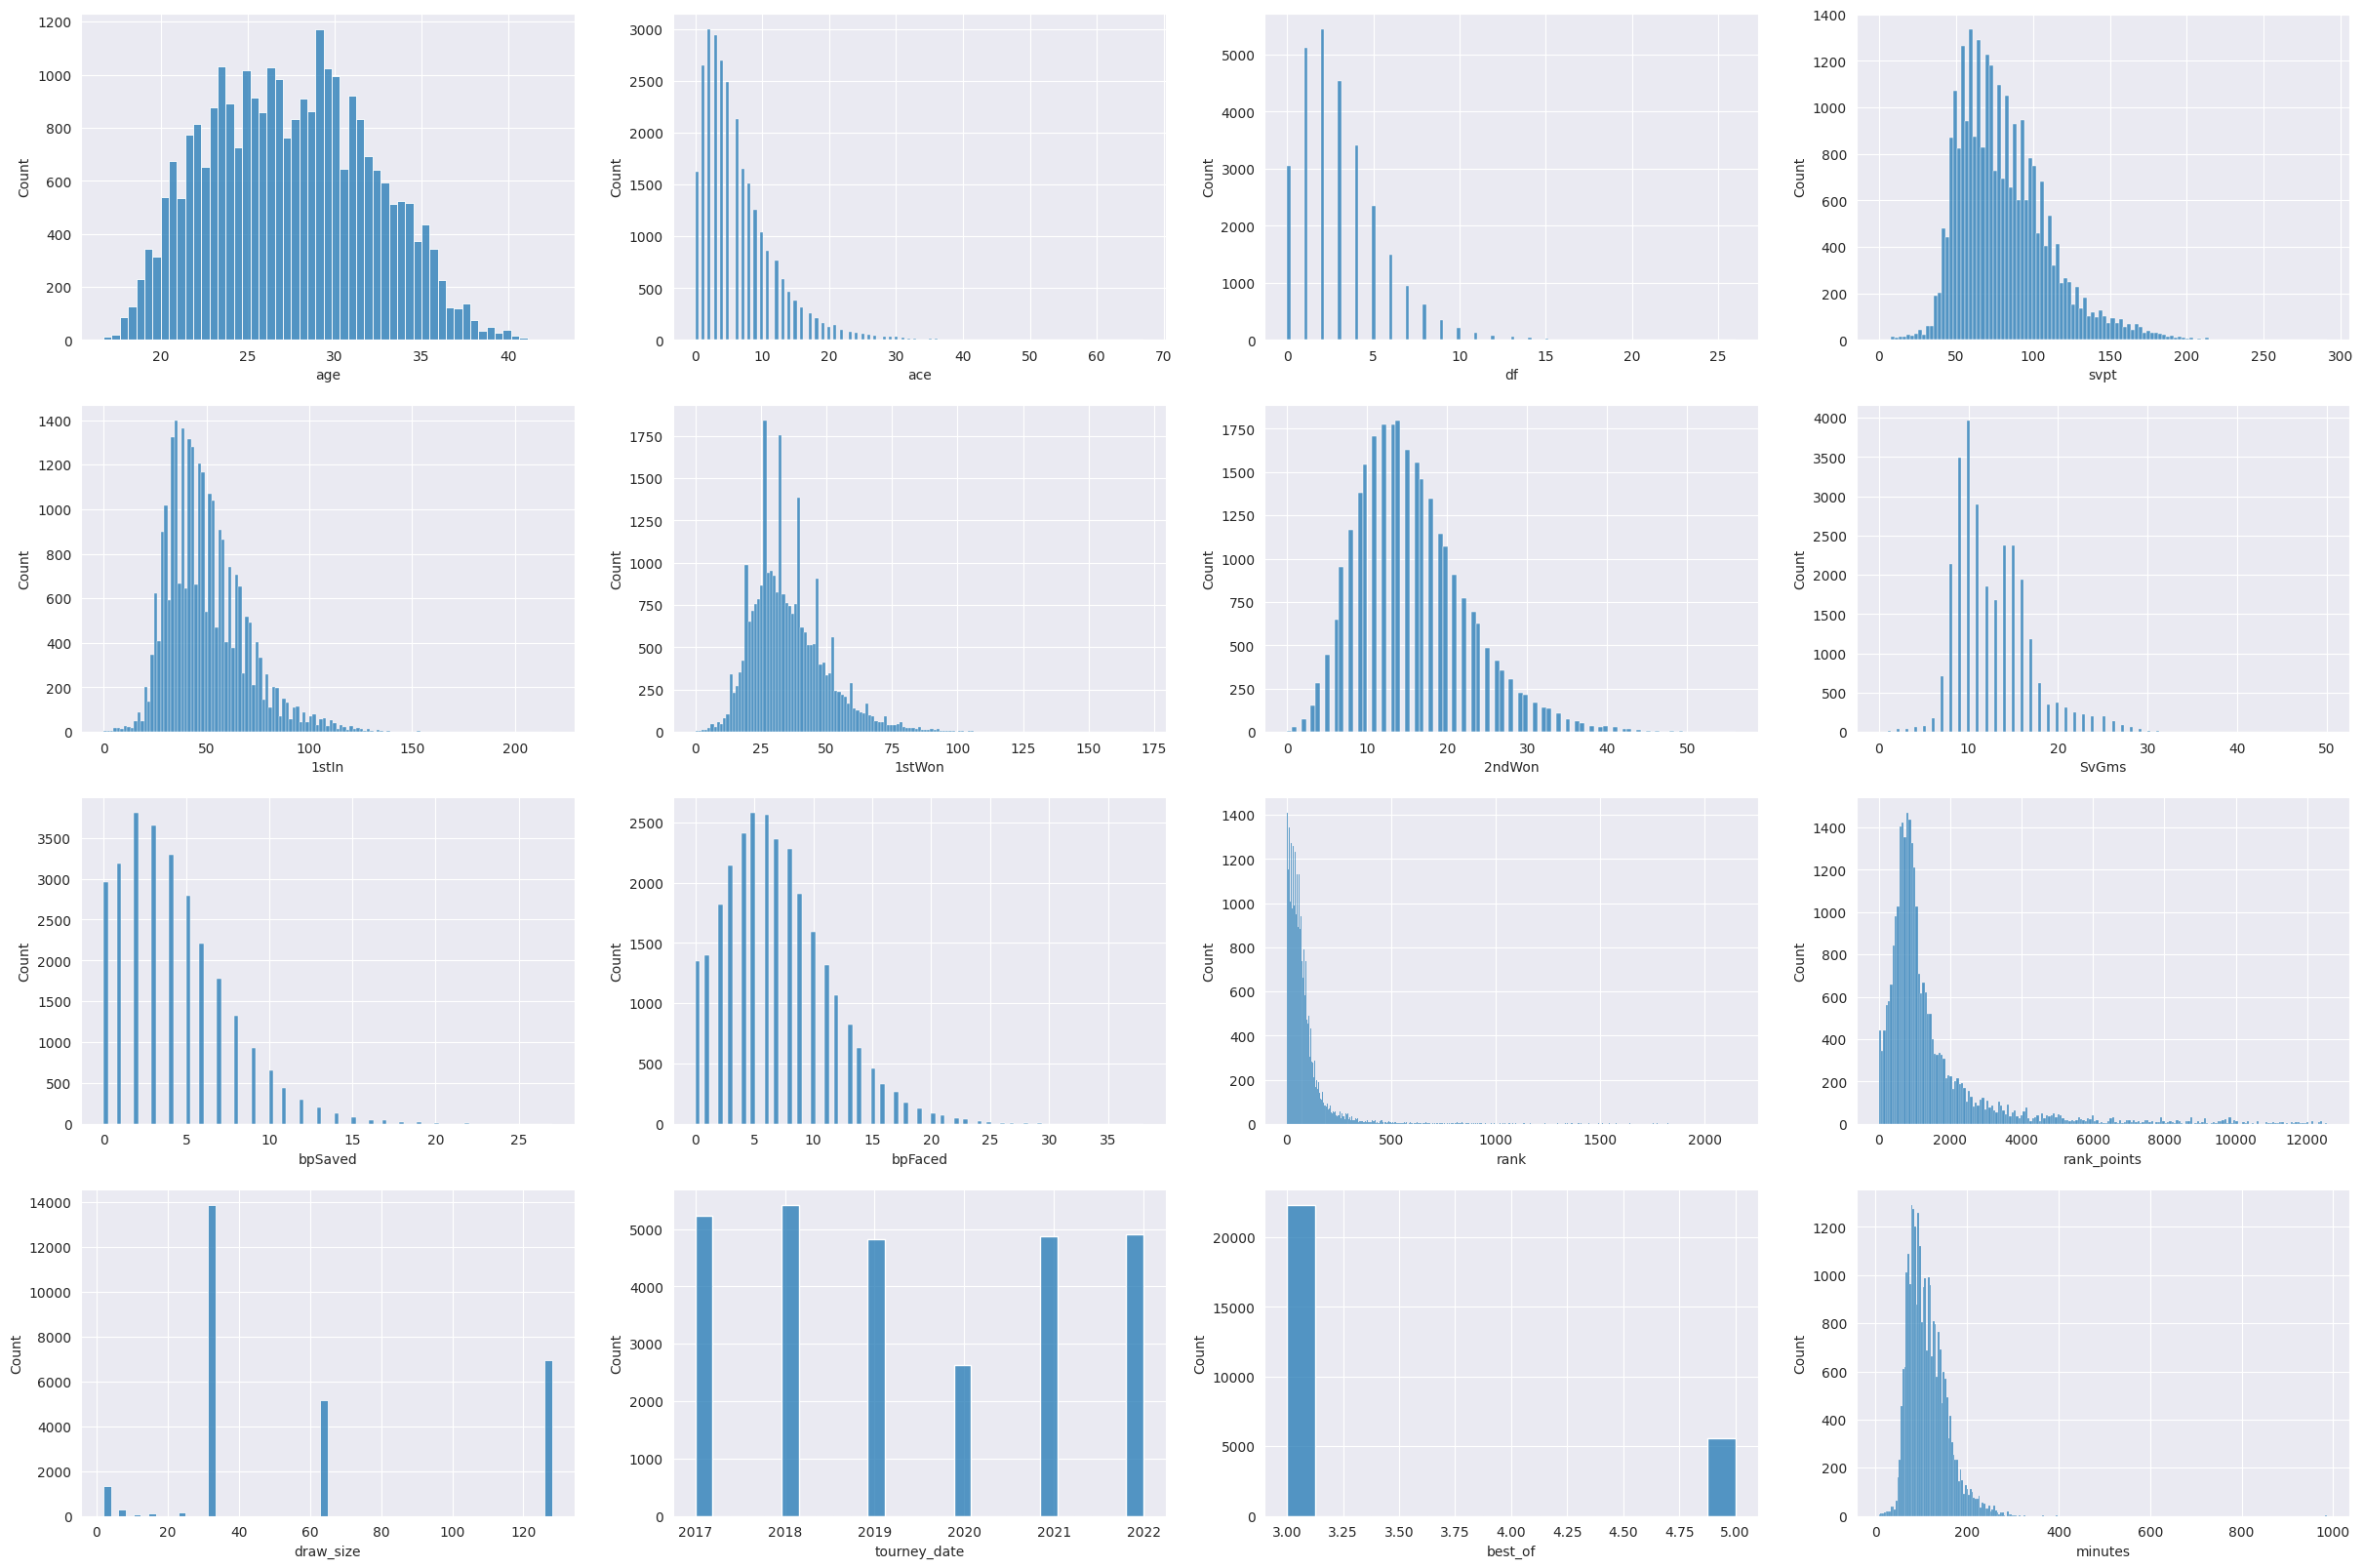

In [11]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(30, 20))

for i, col in enumerate(continuous_var):
  plt.sca(axs[i // 4, i % 4])
  sns.histplot(data=matches_df[col])

- Many variables follow a near-bell curve (age, svpt, 1stIn, 1stwon, 2ndWon, SvGms, minutes) with some high values in the middle
- Most of the variables have an important number of outliers, suggesting that this is not due to wrong data but rather a common phenomena

Following these observations, we will process our data using Standardization, which will be suited for near-normal distributions and keep the meaning of outliers.

## 2. Data Preprocessing

In [12]:
# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler


### Split data between train and test sets


In [13]:
test_proportion = 0.2
target = matches_df["won"]
features = matches_df.drop(columns='won')

datasets = train_test_split(features, target, test_size=test_proportion, shuffle=True, stratify=target)

In [14]:
train_features, test_features, train_target, test_target = datasets

### One-hot encode categorical features


In [15]:
encoder = OneHotEncoder(sparse_output=False).fit(train_features[categorical_var])

In [16]:
def one_hot_encode(features):
  return pd.DataFrame(encoder.transform(features[categorical_var]), columns=encoder.get_feature_names_out())

In [17]:
one_hot_train = one_hot_encode(train_features)
one_hot_test = one_hot_encode(test_features)

### Standardize continuous features

[Justification](#continuous-variables-distribution)

In [18]:
scaler = StandardScaler().fit(train_features[continuous_var])

In [19]:
def scale(features):
  return pd.DataFrame(scaler.transform(features[continuous_var]), columns=scaler.get_feature_names_out())

In [20]:
scale_train = scale(train_features)
scale_test = scale(test_features)

### Creating the final datasets

In [21]:
train_dataset = pd.concat([one_hot_train, scale_train], axis=1)
test_dataset = pd.concat([one_hot_test, scale_test], axis=1)

## 3. Model training and evaluation

Now that our dataset has been preprocessed, we can use it train Machine Learning models.

In [22]:
# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC # Support Vector Machine for classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB

In [23]:
# Performance metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report

### Training various models

We'll then compute their accuracy and F1-score to choose one of them.

In [24]:
models = {
  'Logistic Regression': LogisticRegression(),
  'KNN': KNeighborsClassifier(),
  'SVM': SVC(),
  'Decision Tree': DecisionTreeClassifier(),
  'Random Forest': RandomForestClassifier(),
  'Naive Bayes': GaussianNB(),
  'Ada Boost': AdaBoostClassifier(),
}

for name, model in models.items():
  print(f'Training model {name}')
  model.fit(train_dataset, train_target)

Training model Logistic Regression
Training model KNN
Training model SVM
Training model Decision Tree
Training model Random Forest
Training model Naive Bayes
Training model Ada Boost


/home/theovld/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### Choice of one model

In [25]:
for name, model in models.items():
  test_predicted = model.predict(test_dataset)
  accuracy = accuracy_score(test_target, test_predicted)
  f1 = f1_score(test_target, test_predicted, average='macro')
  print(f'----- {name} -----')
  print(f'Accuracy: {accuracy:.4f}')
  print(f'F1 Score: {f1:.4f}')

----- Logistic Regression -----
Accuracy: 0.8139
F1 Score: 0.8130
----- KNN -----
Accuracy: 0.6994
F1 Score: 0.6977
----- SVM -----
Accuracy: 0.8021
F1 Score: 0.8012
----- Decision Tree -----
Accuracy: 0.7130
F1 Score: 0.7117
----- Random Forest -----
Accuracy: 0.7743
F1 Score: 0.7722
----- Naive Bayes -----
Accuracy: 0.6616
F1 Score: 0.6578
----- Ada Boost -----
Accuracy: 0.7853
F1 Score: 0.7828


The best model so far seems to be the Logistic Regression. There could be some reasons for this result:

- Distance-based algorithms are based on geometrical assumptions (euclidian distance), but we one-encoded many features so the resulting vector space doesn't make much sense
- Tree-based models can easily catch the numerous outliers our dataset contains, resulting in overfitting (the problem is thus similar for the Random Forest algorithm, although less present)
- Gaussian Naive Bayes assumes that all values are normally distributed, which is not the case for one-hot encoded features

### Correlation matrix

In [26]:
best_model = models['Logistic Regression']
test_predicted = best_model.predict(test_dataset)

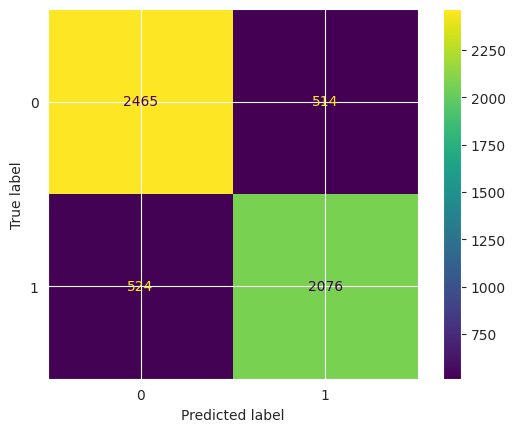

In [27]:
cm = confusion_matrix(test_target, test_predicted)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_).plot()

### Precision/Recall curve

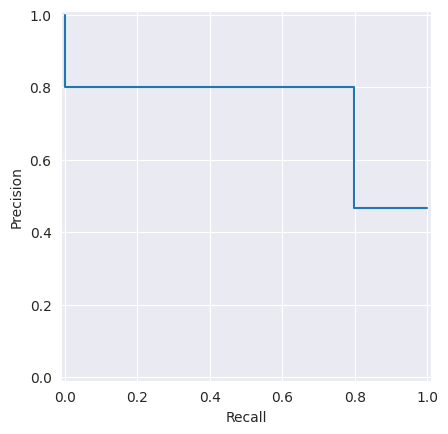

In [28]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

prec, recall, _ = precision_recall_curve(test_target, test_predicted)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

### ROC AUC Score

In [29]:
roc_auc_score(test_target, test_predicted)

0.812960208639967

### ROC Curve

/home/theovld/.local/lib/python3.10/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


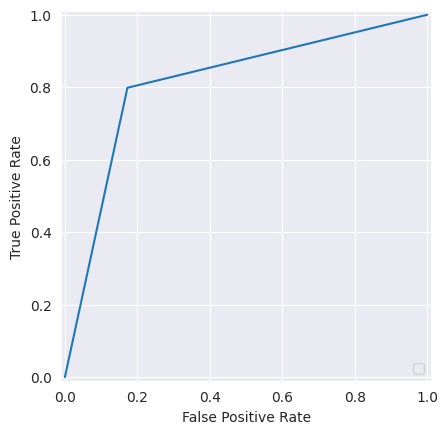

In [30]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(test_target, test_predicted)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
print(classification_report(test_target, test_predicted))

## 4. Improving the performance

In [31]:
# Improve your model
from sklearn.model_selection import GridSearchCV

In [32]:
best_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Hyperparameter grid search

In [ ]:
search_space = GridSearchCV(
  estimator=best_model,
  param_grid={
    'C': np.linspace(-3, 3, 10),
    'tol': np.linspace(1e-5, 1e-3, 10),
    'class_weight': ['balanced', None],
    'max_iter': [100, 1000],
    'penalty': ['l2', 'elasticnet']
  },
  scoring='f1'
)

In [ ]:
search_space.fit(train_dataset, train_target)

In [ ]:
search_space.best_params_

In [ ]:
search_space.best_score_

### Using the results to train a new model

In [33]:
improved_model = LogisticRegression(
  C=1/3,
  class_weight='balanced',
  max_iter=100,
  penalty='l2',
  tol=6.7e-4
)
improved_model.fit(train_dataset, train_target)

LogisticRegression(C=0.3333333333333333, class_weight='balanced', tol=0.00067)

### Metrics comparison

In [34]:
improved_test_prediction = improved_model.predict(test_dataset)

In [47]:
print('-------- Best model: ---------')
print(classification_report(test_target, test_predicted))

-------- Best model: ---------
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      2979
           1       0.80      0.80      0.80      2600

    accuracy                           0.81      5579
   macro avg       0.81      0.81      0.81      5579
weighted avg       0.81      0.81      0.81      5579



In [48]:
print('-------- Improved version: -------')
print(classification_report(test_target, improved_test_prediction))

-------- Improved version: -------
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      2979
           1       0.79      0.82      0.80      2600

    accuracy                           0.81      5579
   macro avg       0.81      0.81      0.81      5579
weighted avg       0.81      0.81      0.81      5579



Metrics are very similar between both models on the test set. We have achieved quite good results concerning Logistic Regression

### ROC Curve

/home/theovld/.local/lib/python3.10/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


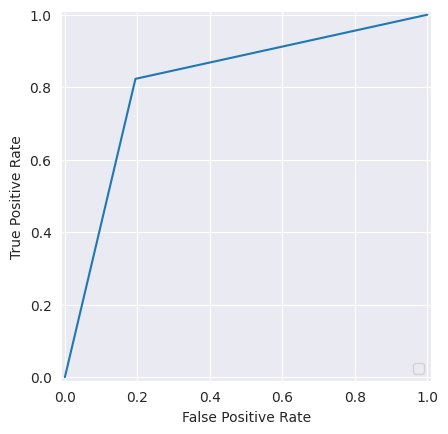

In [36]:
fpr, tpr, _ = roc_curve(test_target, improved_test_prediction)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

### Confusion matrix

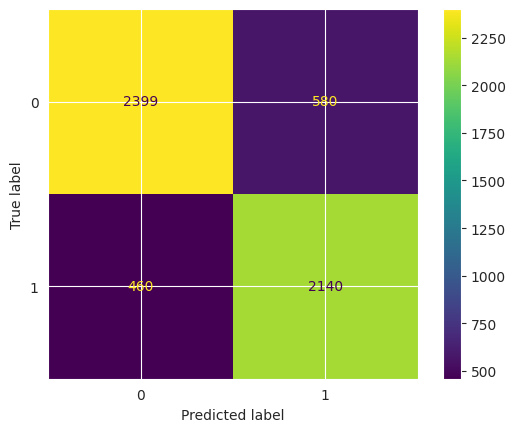

In [37]:
cm = confusion_matrix(test_target, improved_test_prediction)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=improved_model.classes_).plot()

## 5. Explainability with shap

In [ ]:
!pip install shap

In [38]:
import shap
np.bool=bool # code from last year

### Running the Explainer on the improved Logistic Regression model

In [39]:
explainer = shap.Explainer(improved_model.predict_proba, train_dataset[:300], feature_names=train_dataset.columns)

In [40]:
shap_values = explainer(test_dataset[:300])

PermutationExplainer explainer: 301it [00:10,  2.61it/s]                         


### Results

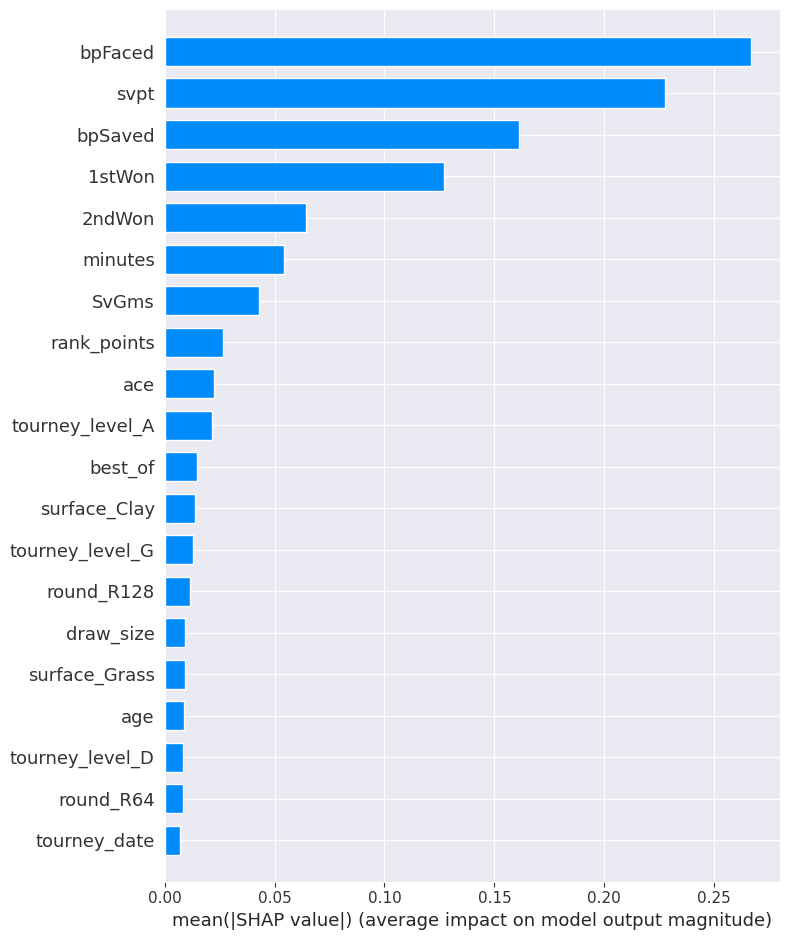

In [41]:
shap.summary_plot(shap_values[:, :, 0], plot_type='bar')

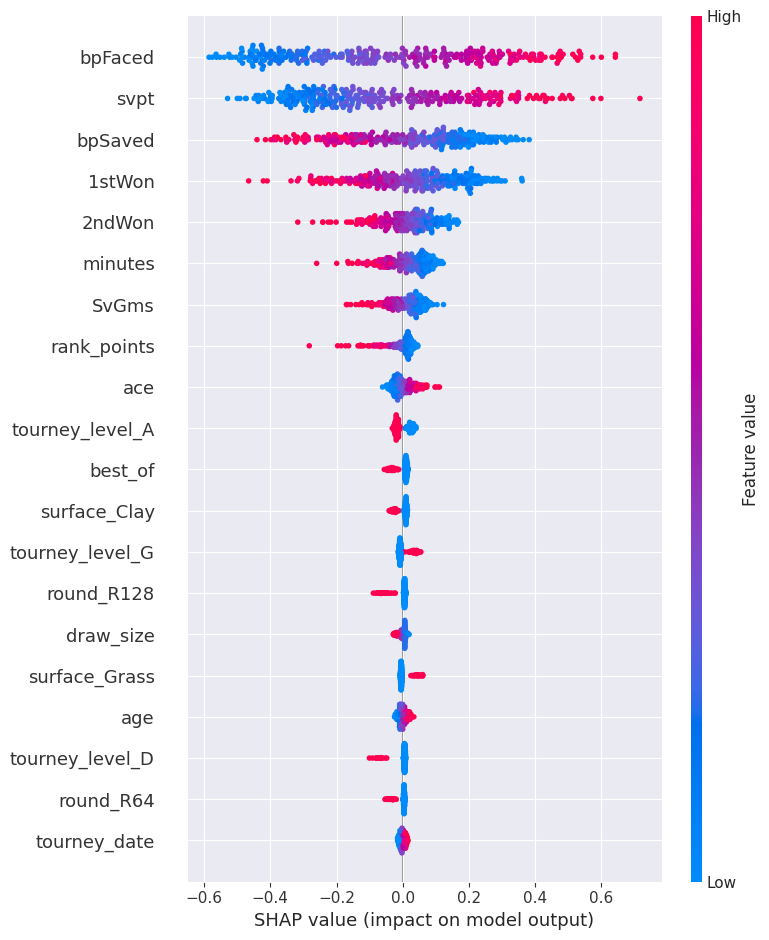

In [42]:
shap.summary_plot(shap_values[:, :, 0], plot_type='dot')

All breakpoints combined have the greatest impact, followed by serve percent. Overall, breaks and services have the most influence.

## 6. Deep Learning

We will start by importing one of Python's Deep Learning libraries `tensorflow`/`keras`.

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

2024-08-23 12:10:38.057179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 12:10:38.228712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 12:10:38.285667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 12:10:38.658883: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 12:10:40.576823: W tensorflow/compiler/tf2

In [45]:
model = Sequential([
  Dense(32, activation='relu'),
  Dropout(0.5),
  Dense(1, activation='sigmoid') # Output a probability
])
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy']
)
model.fit(
  train_dataset,
  train_target,
  validation_split=0.2,
  epochs=10
)

Epoch 1/10


I0000 00:00:1724407841.936259   18458 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724407842.280197   18458 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724407842.280521   18458 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724407842.282828   18458 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

 79/558 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5479 - loss: 0.7043

I0000 00:00:1724407845.344012   18776 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6164 - loss: 0.6451 - val_accuracy: 0.7338 - val_loss: 0.5239
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7267 - loss: 0.5240 - val_accuracy: 0.7697 - val_loss: 0.4664
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7514 - loss: 0.4833 - val_accuracy: 0.7871 - val_loss: 0.4359
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7794 - loss: 0.4476 - val_accuracy: 0.7948 - val_loss: 0.4164
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7840 - loss: 0.4366 - val_accuracy: 0.7954 - val_loss: 0.4051
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7945 - loss: 0.4260 - val_accuracy: 0.7954 - val_loss: 0.4006
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7956 - loss: 0.4211 - val_accuracy: 0.8004 - val_loss: 0.3963
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7946 - loss: 0.4172 - val_accuracy: 0.8010 - val_

In [46]:
model.evaluate(test_dataset, test_target)

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8045 - loss: 0.3929


[0.3903008997440338, 0.8039075136184692]

Not that bad! Our model seems to neither underfit or overfit too much, since train and validation losses are close to each other for several epochs starting at number 6.